In [6]:
from neural_network import NeuralNetwork
import numpy as np
from losses import bce, bce_deriv
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

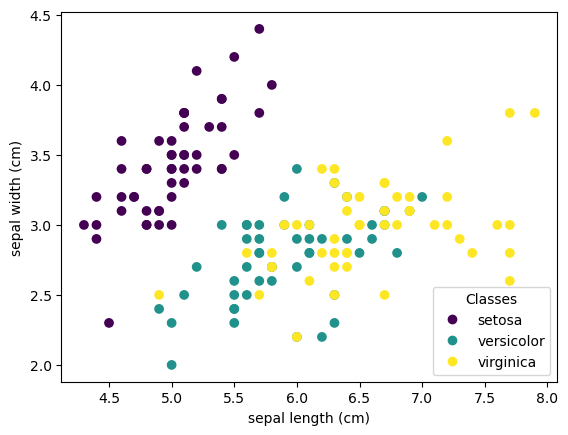

In [7]:
iris = datasets.load_iris()

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [8]:
inputs = iris.data

# Since each prediction is a vector with a score for each of the three types of flowers,
# we need to make each target a vector with a 1 for the correct flower and a 0 for the others.
targets = np.zeros((len(iris.data), 3))
for i, t in enumerate(iris.target):
    targets[i, t] = 1


def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)

    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

Epoch 100 | train: 0.492343 | val: 0.514688
Epoch 200 | train: 0.419618 | val: 0.447889
Epoch 300 | train: 0.382439 | val: 0.413769
Hidden layers=0, nodes=5 -> test acc=0.767
Epoch 100 | train: 0.510098 | val: 0.540957
Epoch 200 | train: 0.431886 | val: 0.469777
Epoch 300 | train: 0.391879 | val: 0.433595
Hidden layers=0, nodes=10 -> test acc=0.800
Epoch 100 | train: 0.559981 | val: 0.583269
Epoch 200 | train: 0.470025 | val: 0.499372
Epoch 300 | train: 0.424537 | val: 0.457341
Hidden layers=0, nodes=25 -> test acc=0.767
Epoch 100 | train: 0.393151 | val: 0.427088
Epoch 200 | train: 0.341285 | val: 0.379423
Epoch 300 | train: 0.313066 | val: 0.353317
Hidden layers=0, nodes=50 -> test acc=0.900
Epoch 100 | train: 0.328763 | val: 0.397405
Epoch 200 | train: 0.239884 | val: 0.302813
Epoch 300 | train: 0.193713 | val: 0.248705
Hidden layers=1, nodes=5 -> test acc=0.867
Epoch 100 | train: 0.261201 | val: 0.330551
Epoch 200 | train: 0.206737 | val: 0.283844
Epoch 300 | train: 0.177898 | val:

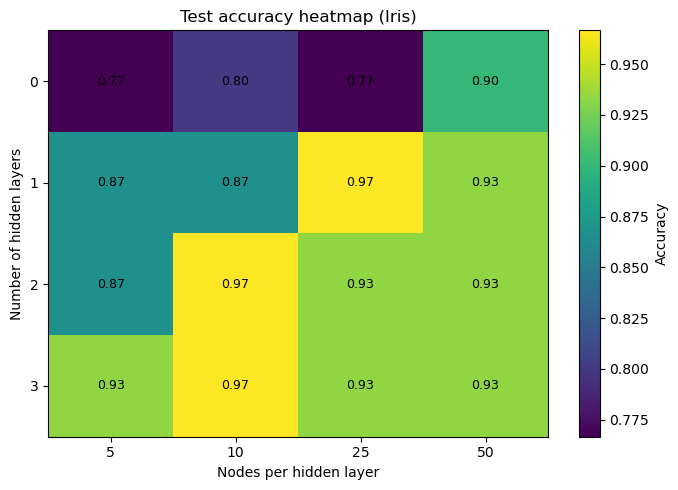

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from neural_network import NeuralNetwork
from losses import cross_entropy_with_logits, cross_entropy_with_logits_deriv
from activations import relu, relu_deriv, sigmoid, sigmoid_deriv, linear, linear_deriv
from optimizers import Adagrad

# --- Data og preprocessing ---
iris = datasets.load_iris()
X = iris.data.astype(float)
y = iris.target

# One-hot targets (3 klasser)
Y = np.zeros((len(y), 3), dtype=float)
Y[np.arange(len(y)), y] = 1.0

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Accuracy-hjelper ---
def accuracy(predictions, targets_onehot):
    # predictions forventes å være (N, 3) – sannsynligheter per klasse
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(targets_onehot, axis=1)
    return np.mean(y_pred == y_true)

# --- Grid av arkitekturer ---
hidden_layers_list = [0, 1, 2, 3]
nodes_per_layer_list = [5, 10, 25, 50]
acc_matrix = np.zeros((len(hidden_layers_list), len(nodes_per_layer_list)))

for i, n_hidden in enumerate(hidden_layers_list):
    for j, n_nodes in enumerate(nodes_per_layer_list):
        # Lagliste: [skjulte ..., output]
        if n_hidden == 0:
            layer_output_sizes = [3]        # kun output-lag
            acts = [linear]                # output: sigmoid (BCE én-vs-alle)
            ders = [linear_deriv]
        else:
            layer_output_sizes = [n_nodes] * n_hidden + [3]
            # skjulte: ReLU, output: sigmoid
            acts = [relu] * n_hidden + [linear]
            ders = [relu_deriv] * n_hidden + [linear_deriv]

        model = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=layer_output_sizes,
            activation_funcs=acts,
            activation_ders=ders,
            cost_fun=cross_entropy_with_logits,
            cost_der=cross_entropy_with_logits_deriv,
        )

        # Tilpass til din fit-signatur om nødvendig:
        optimizer = Adagrad(lr=0.01)
        model.fit(
            X_train, Y_train,
            epochs=300,
            batch_size=16,
            optimizer=optimizer,
            X_val=X_test,
            Y_val=Y_test,
            seed=6114, 
            log_every=100
        )

        P_test = model.predict(X_test)   # forventer (N, 3) sannsynligheter
        acc = accuracy(P_test, Y_test)
        acc_matrix[i, j] = acc
        print(f"Hidden layers={n_hidden}, nodes={n_nodes} -> test acc={acc:.3f}")

# --- Heatmap med matplotlib ---
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(acc_matrix, aspect="auto", origin="upper")
# ticks/labels
ax.set_xticks(np.arange(len(nodes_per_layer_list)))
ax.set_yticks(np.arange(len(hidden_layers_list)))
ax.set_xticklabels(nodes_per_layer_list)
ax.set_yticklabels(hidden_layers_list)
ax.set_xlabel("Nodes per hidden layer")
ax.set_ylabel("Number of hidden layers")
ax.set_title("Test accuracy heatmap (Iris)")

# tall over rutene
for i in range(acc_matrix.shape[0]):
    for j in range(acc_matrix.shape[1]):
        ax.text(j, i, f"{acc_matrix[i, j]:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, label="Accuracy")
plt.tight_layout()
plt.show()


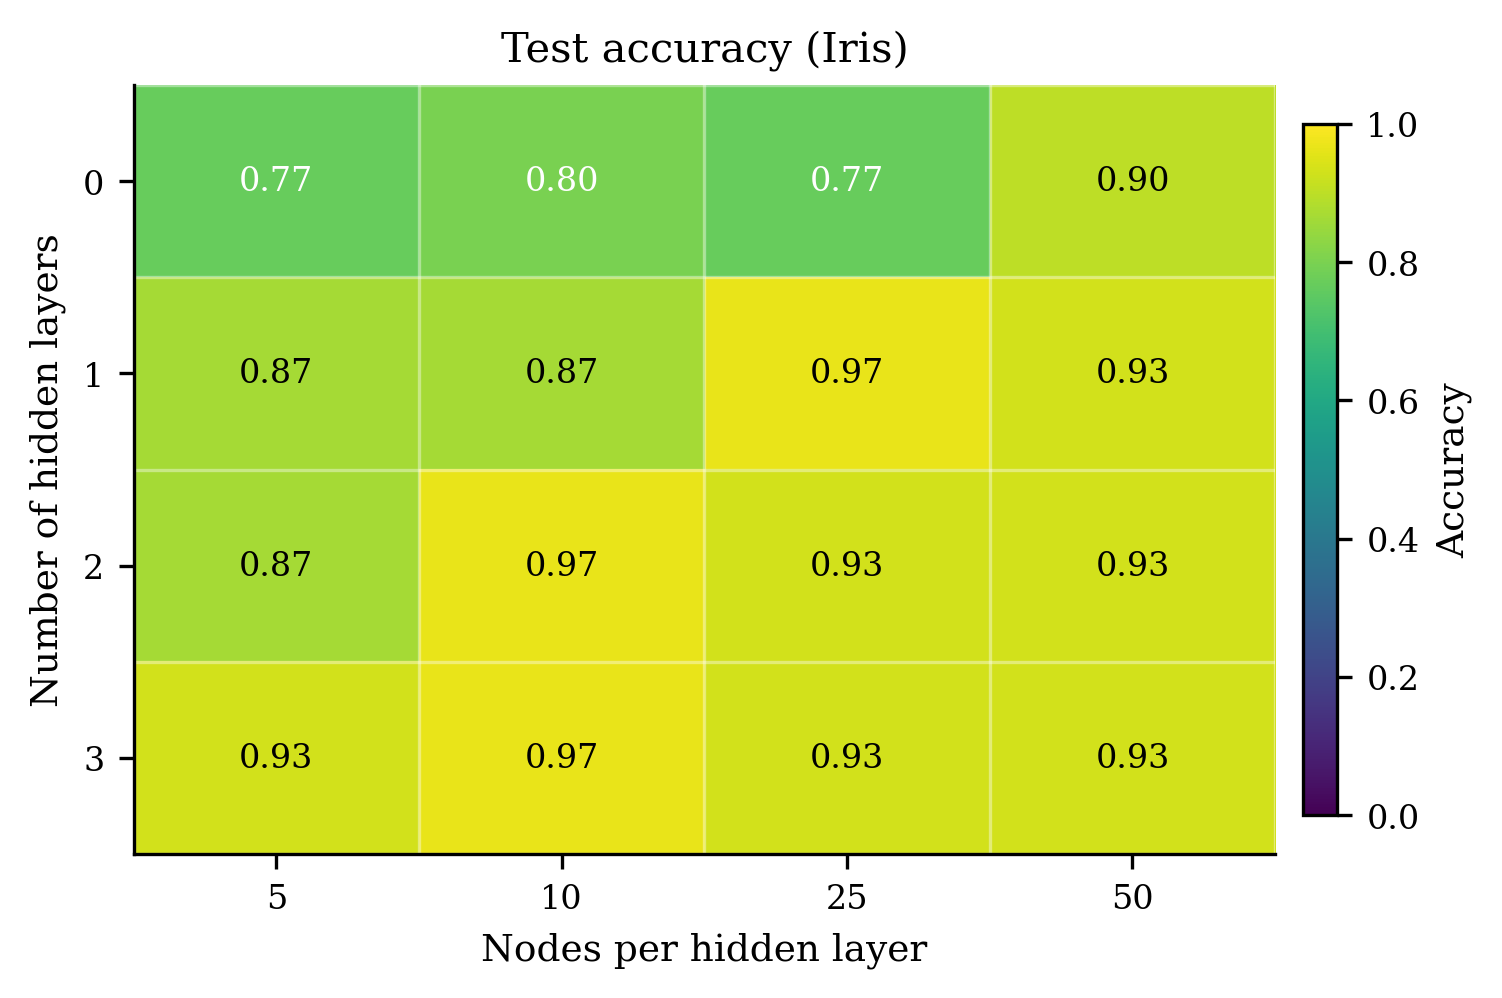

Lagret: iris_nn_heatmap.pdf


In [3]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "pdf.fonttype": 42,  # bedre font-embedding i pdf
    "ps.fonttype": 42,
    "figure.dpi": 300,
})

fig, ax = plt.subplots(figsize=(5.2, 3.4))  # fin bredde/høyde for rapport
im = ax.imshow(
    acc_matrix, aspect="auto", origin="upper",
    interpolation="nearest", cmap="viridis",
    vmin=0.0, vmax=1.0
)

# Ticks/labels
ax.set_xticks(np.arange(len(nodes_per_layer_list)))
ax.set_yticks(np.arange(len(hidden_layers_list)))
ax.set_xticklabels(nodes_per_layer_list)
ax.set_yticklabels(hidden_layers_list)
ax.set_xlabel("Nodes per hidden layer")
ax.set_ylabel("Number of hidden layers")
ax.set_title("Test accuracy (Iris)")

# Diskré rutenett via minor ticks
ax.set_xticks(np.arange(-.5, acc_matrix.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, acc_matrix.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linewidth=0.8, alpha=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# Tall i rutene med kontrastfarge
threshold = (acc_matrix.max() + acc_matrix.min()) / 2.0
for i in range(acc_matrix.shape[0]):
    for j in range(acc_matrix.shape[1]):
        color = "white" if acc_matrix[i, j] < threshold else "black"
        ax.text(j, i, f"{acc_matrix[i, j]:.2f}", ha="center", va="center", fontsize=8, color=color)

# Tynn ramme, fjern topp/høyre
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Kompakt colorbar
cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
cbar.set_label("Accuracy")

fig.tight_layout()
fig.savefig("iris_nn_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()
print("Lagret: iris_nn_heatmap.pdf")









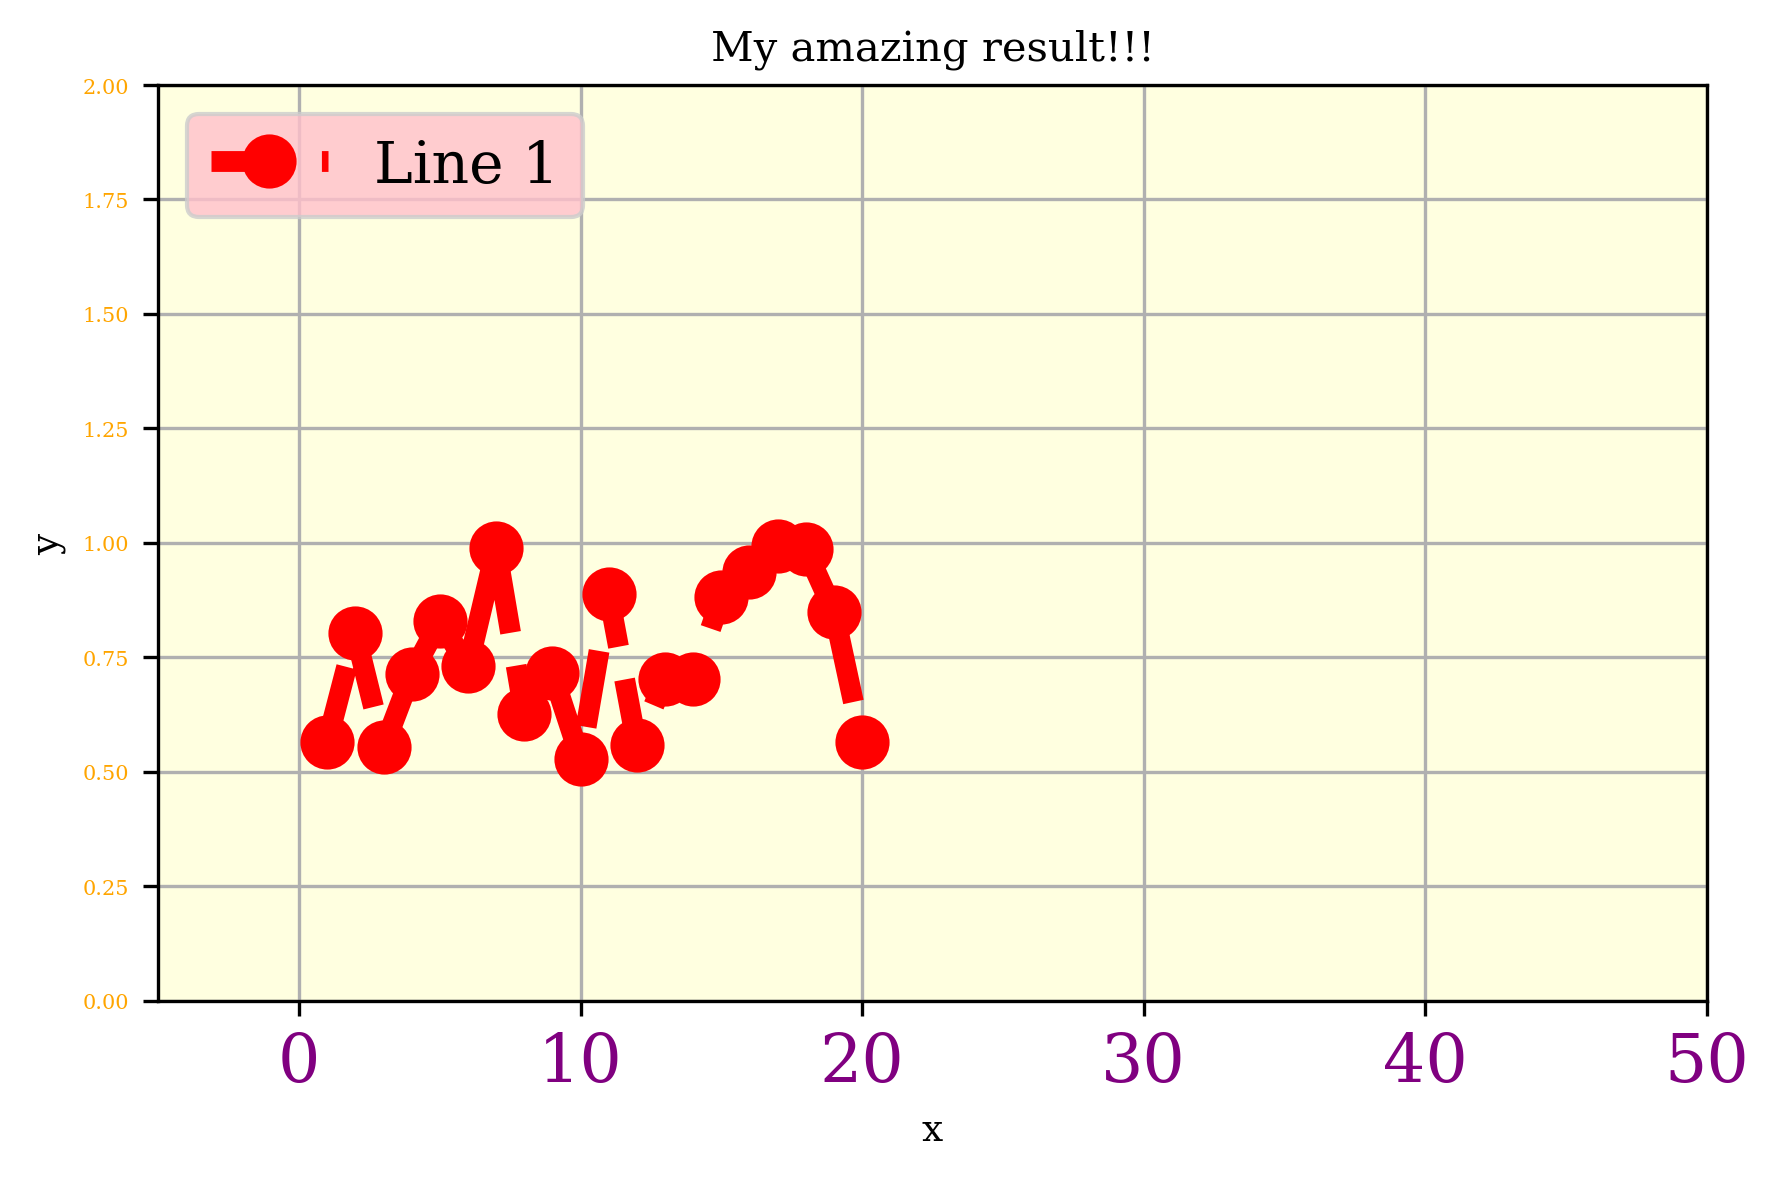

Lagret: bad_figure.pdf


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Eksempeldata: test accuracy over epochs
epochs = np.arange(1, 21)
accuracy = np.random.rand(20) * 0.5 + 0.5  # tilfeldig "resultat"

plt.figure(figsize=(6, 4))

# Dårlige valg (med vilje)
plt.plot(epochs, accuracy, 'r--o', linewidth=5, markersize=12)  # altfor tykk linje
plt.title("My amazing result!!!")  # lite informativ tittel
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

# Distraherende bakgrunn
plt.gca().set_facecolor("lightyellow")

# Uklare grenser, ingen forklaring på hva som måles
plt.xlim(-5, 50)
plt.ylim(0, 2)

# Dårlig font og farger
plt.xticks(fontsize=16, color='purple')
plt.yticks(fontsize=5, color='orange')

plt.legend(["Line 1"], loc="upper left", fontsize=14, frameon=True, facecolor="pink")

plt.tight_layout()
plt.savefig("bad_figure.pdf")
plt.show()
print("Lagret: bad_figure.pdf")
